In [194]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore', 'overflow encountered in exp')

np.random.seed(13)

In [195]:
df = pd.DataFrame(pd.read_csv('data/digit recognizer/train.csv'))
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use binary classification. This means we will only use numbers one and zero first, before doing a more complex classification problem with multiple numbers.

In [196]:
df = df.loc[df['label'].isin([0, 1])]
x_train = df.drop("label", axis=1)
y_train = df["label"]

m, n = x_train.shape

Plot data

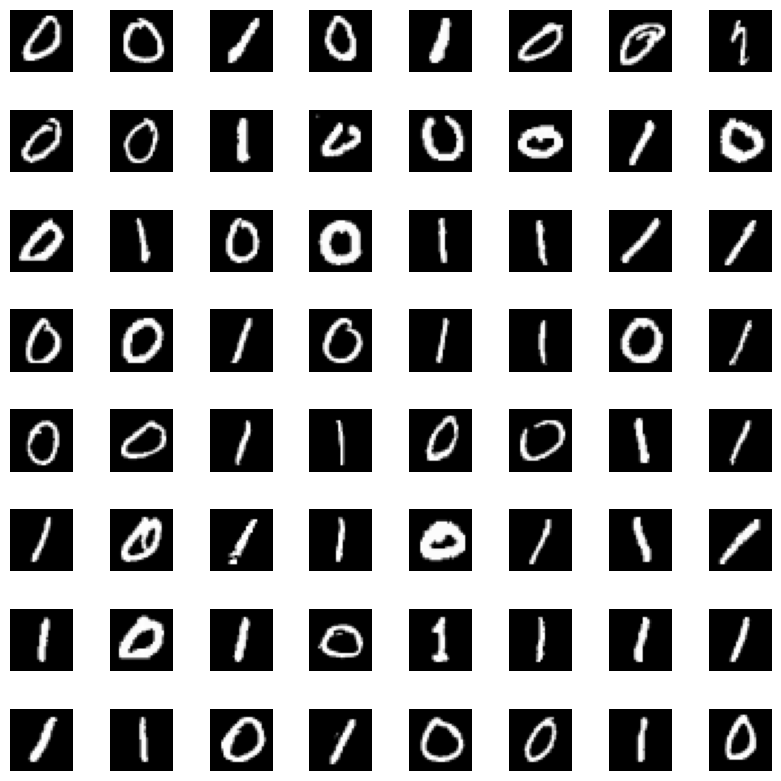

In [197]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    #ax.set_title(y_train[random_index])
    ax.set_axis_off()


# Neural Network

## Model

### Tensorflow Implementation

The neural network will be implemented first with tensorflow and then using our on math implementation with numpy.The NN will have this caracteristics:

- Three dense layers with sigmoid activations functions.
    - Inputs are pixel values of digit images.
    - Since the images are of size $28\times28$, this gives us $784$ inputs 

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (1,n) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 

First let's implement with tensorflow.

Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated automatically. The layer's *output dimensions* are specified and it determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statement below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

In [198]:
model = Sequential(
    [               
        tf.keras.Input(shape=(784,)),    # the images are 28 x 28 = 784
        Dense(units=25, activation='sigmoid'),
        Dense(units=15, activation='sigmoid'),
        Dense(units=1, activation='sigmoid')
        
    ], name = "my_model" 
)  

In [199]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 25)             │        19,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,031 (78.25 KB)

 Trainable params: 20,031 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

Layer n num params = W[n] + b[n]
$$

L_1 = 769 * 25 + 25 = 19.625 \\
L2 = 25 * 15 + 15 = 390 \\
L3 = 15 * 1 + 1 = 16
$$

We can examine details of the model by first extracting the layers with `model.layers` and then extracting the weights with `layerx.get_weights()` as shown below.

In [200]:
[layer1, layer2, layer3] = model.layers

# Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [201]:
print(model.layers[2].weights)

[<KerasVariable shape=(15, 1), dtype=float32, path=my_model/dense_8/kernel>, <KerasVariable shape=(1,), dtype=float32, path=my_model/dense_8/bias>]


We will define a loss function and run gradient descent to fit the weights of the model to the training data.

In [202]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    x_train, y_train,
    epochs=20
)

Epoch 1/20


276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - loss: 0.3894
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.0595
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.0254
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.0154
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 0.0109
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0081
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.0067
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.0052
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.0054
Epoch 10/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 0.0049
Epoch 11/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 0.0044
Epoch 12/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.0029
Epoch 13/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.0033
Epoch 14/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 0.0033
Epoch 15/20
276/276 ━━━━━━━━━━━━━━━━━━━━

The model predicts the probability that the input is a one is nearly one and the probability of a zero input to be one is nearly a zero. As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [203]:
def prediction_thold(prediction):
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    return yhat

Now we will make predictions.

In [204]:
prediction = model.predict(x_train.iloc[[1]])  # a one
print(f" predicting a zero: {prediction}")
print(f"prediction after threshold: {prediction_thold(prediction)}")
prediction = model.predict(x_train.iloc[[0]])  # a zero
print(f" predicting a one:  {prediction}")
print(f"prediction after threshold: {prediction_thold(prediction)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 predicting a zero: [[0.00026624]]
prediction after threshold: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 predicting a one:  [[0.99941397]]
prediction after threshold: 1


### Numpy Implementation (Forward Prop)

In [205]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z
    """
    
    return 1/(1 + np.exp(-z))

def dense_layer(a_in, w, b, g):
    
    # Alternative using dot product:
    '''
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        a_out[j] = np.dot(W[:, j], a_in) + b[j]
    a_out = g(a_out)
    '''
    
    # Using matrix multiplication
    a_out = g(np.matmul(a_in, w) + b)
    
    return a_out

def sequential(a_in, w, b):
    
    for i in range(len(w)):
        a_out = dense_layer(a_in, w[i], b[i], sigmoid)
        a_in = a_out
    
    return(a_out)

By coping tensorflow weights we can test our numpy model

In [206]:
W_tmp=[]
b_tmp=[]
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

W_tmp = [W1_tmp, W2_tmp, W3_tmp]
b_tmp = [b1_tmp, b2_tmp, b3_tmp]

In [207]:
prediction = sequential(x_train.iloc[0], W_tmp, b_tmp)
print(f"prediction: {prediction_thold(prediction)}, label= {y_train.iloc[0]}")

prediction = sequential(x_train.iloc[1], W_tmp, b_tmp)
print(f"prediction: {prediction_thold(prediction)}, label= {y_train.iloc[1]}")


prediction: 1, label= 1
prediction: 0, label= 0


Plot predictions with both models

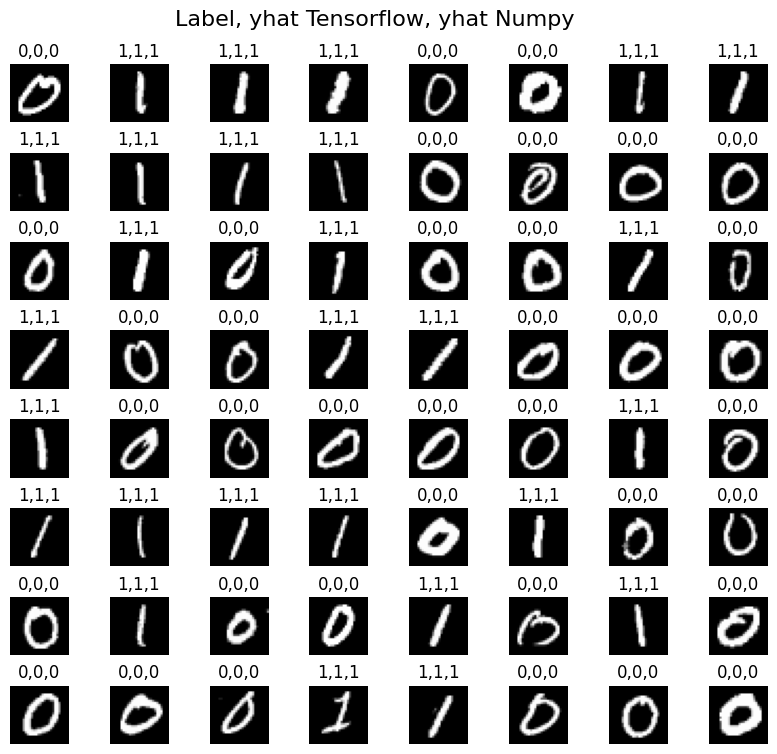

In [211]:
n = x_train.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = x_train.iloc[random_index].values.reshape((28, 28))
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = prediction_thold(sequential(x_train.iloc[random_index], W_tmp, b_tmp))

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = prediction_thold(model.predict(x_train.iloc[[random_index]], verbose = 0))
    
    # Display the label above the image
    ax.set_title(f"{y_train.iloc[random_index]},{tf_prediction},{my_prediction}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()